In [22]:
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import numpy as np

In [33]:
def load_image_dataset(path_to_images, resize=None):
    paths = glob.glob(path_to_images)

    dataset = None

    if resize:
        dataset = np.zeros((len(paths), resize[0], resize[1], 3))
    else:
        dataset = np.zeros((len(paths), 512, 512, 3))

    for i, path_to_img in enumerate(paths):
        img = keras.utils.load_img(path_to_img)
        img = keras.preprocessing.image.img_to_array(img)

        if resize:
            img = tf.image.resize(img, resize)

        img = img / 255.
        dataset[i] = img
    return dataset

In [34]:
x_train = load_image_dataset('../data/kpop/training/*', (128, 128))

In [4]:
image_size = (512, 512)

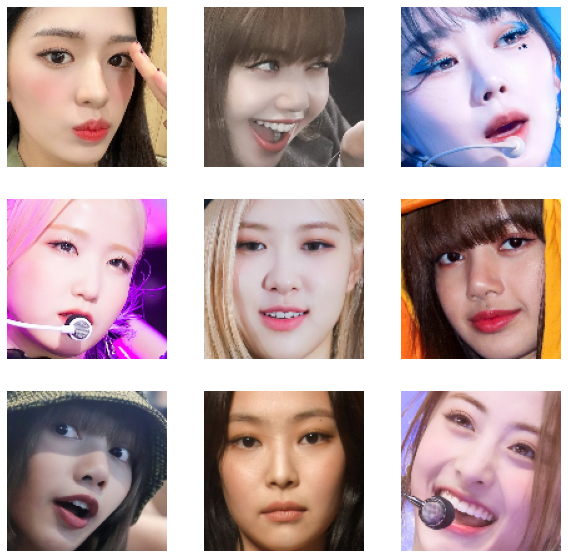

In [35]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i])
    plt.axis("off")

In [36]:
# input_img = keras.Input(shape=(128, 128, 3))
#
# x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
#
# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# x = layers.UpSampling2D((2, 2))(x)
# decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
#
# autoencoder = keras.Model(input_img, decoded)

In [42]:
encoded_input = keras.Input(shape=(128, 128, 3), name="image_input")
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(encoded_input)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(512, activation='relu')(x)

model_encoder = keras.Model(encoded_input, encoder_output, name='model_encoder')

decoder_input = keras.layers.Dense(16384, activation='relu')(encoder_output)

x = keras.layers.Reshape((16, 16, 64))(decoder_input)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)

decoded = layers.Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same')(x)

autoencoder = keras.Model(encoded_input, decoded, name='model_cnn_autoencoder')

In [43]:
autoencoder.summary()

Model: "model_cnn_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 6

In [44]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [45]:
autoencoder.fit(x_train, x_train,
                epochs=3,
                batch_size=128,
                shuffle=True,
                validation_split=0.10,
                callbacks=[TensorBoard(log_dir='../data/autoencoder')])

2022-08-15 22:17:44.584987: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-15 22:17:44.585015: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-15 22:17:44.585650: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/3


2022-08-15 22:17:48.421018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/40 [..............................] - ETA: 3:32 - loss: 8.1639

2022-08-15 22:17:53.626005: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-15 22:17:53.626020: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/40 [>.............................] - ETA: 1:02 - loss: 4.6335

2022-08-15 22:17:55.260092: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-15 22:17:55.266851: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-15 22:17:55.275363: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../data/autoencoder/train/plugins/profile/2022_08_15_22_17_55

2022-08-15 22:17:55.276363: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../data/autoencoder/train/plugins/profile/2022_08_15_22_17_55/MacBook-Pro-van-Koray.local.trace.json.gz
2022-08-15 22:17:55.282331: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../data/autoencoder/train/plugins/profile/2022_08_15_22_17_55

2022-08-15 22:17:55.282474: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ../data/autoencoder/train/plugins/profile/2022_08_15

40/40 [==============================] - ETA: 0s - loss: 6.4987

2022-08-15 22:18:55.496349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 69s 2s/step - loss: 6.4987 - val_loss: 6.7031
Epoch 2/3
40/40 [==============================] - 63s 2s/step - loss: 6.6000 - val_loss: 6.7031
Epoch 3/3
40/40 [==============================] - 61s 2s/step - loss: 6.6000 - val_loss: 6.7031
